In [ ]:
#%%

import warnings
warnings.filterwarnings("ignore")
def action_with_warnings():
    warnings.warn("should not appear")
with warnings.catch_warnings(record=True):
    action_with_warnings()
import norgatedata
import quantstats        as qs
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt

[2024-04-19 08:06:43.995560] INFO: Norgate Data: NorgateData package v1.0.74: Init complete


In [ ]:
#%%

def download_history(symbol, start_date):
    return norgatedata.price_timeseries(
        symbol,
        stock_price_adjustment_setting = norgatedata.StockPriceAdjustmentType.TOTALRETURN,
        padding_setting                = norgatedata.PaddingType.NONE,
        start_date                     = start_date,
        timeseriesformat               = 'pandas-dataframe',
        )

In [ ]:
#%%

df = download_history("SPY", "2000-01-01")
df

,Open,High,Low,Close,Volume,Turnover,Unadjusted Close,Dividend
Date,,,,,,,,
2000-01-03,95.099762,95.099762,92.293274,93.295593,12727240.0,1.186205e+09,145.437500,0.0
2000-01-04,92.052719,92.413551,89.566971,89.647156,12611103.0,1.148529e+09,139.750000,0.0
2000-01-05,89.767433,90.769753,88.043449,89.807526,18983998.0,1.704189e+09,140.000000,0.0
2000-01-06,89.566971,90.769753,88.364197,88.364197,9707516.0,8.726070e+08,137.750000,0.0
2000-01-07,90.007996,93.496056,89.847626,93.496056,12574937.0,1.175692e+09,145.750000,0.0
...,...,...,...,...,...,...,...,...
2024-04-12,514.369995,515.815002,509.079987,510.850006,92561096.0,4.742458e+10,510.850006,0.0
2024-04-15,515.130005,515.299988,503.579987,504.450012,92101448.0,4.683707e+10,504.450012,0.0
2024-04-16,504.940002,506.500000,502.209991,503.529999,73484016.0,3.704812e+10,503.529999,0.0


<Axes: xlabel='Date'>

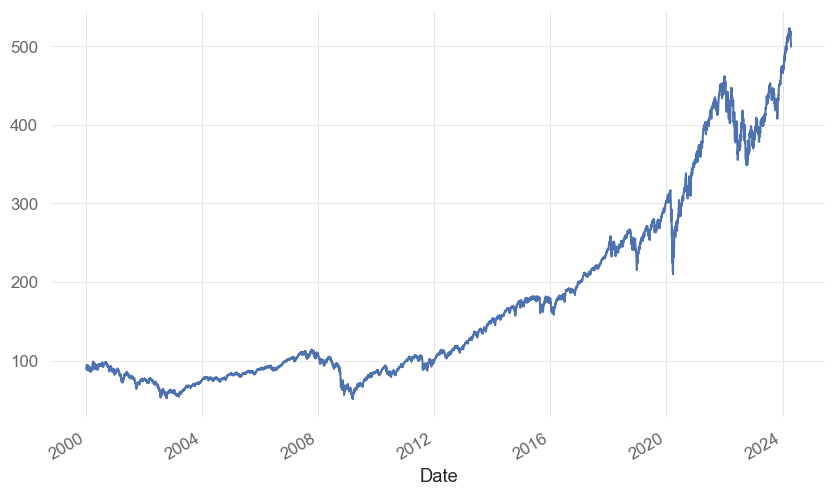

In [ ]:
#%%

df['Close'].plot()

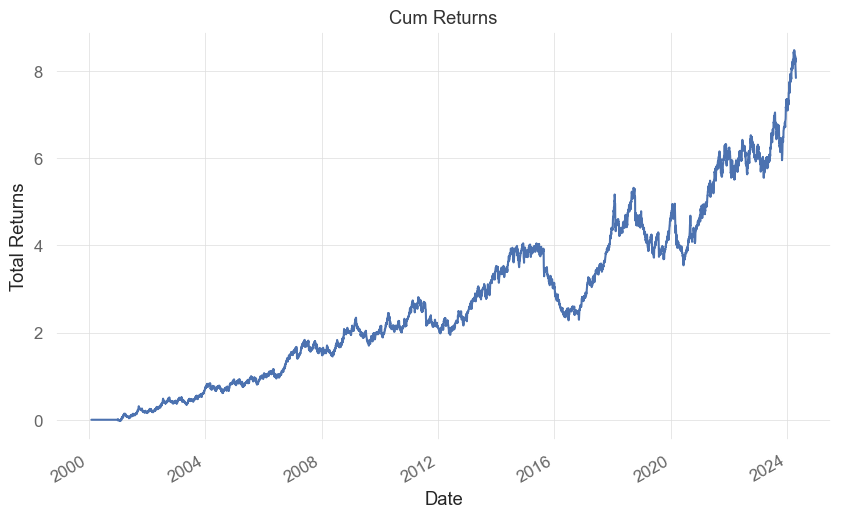

In [ ]:
#%%

short_window = 50
long_window  = 252

short_ma = df['Close'].rolling(window=short_window, min_periods=short_window).mean()
long_ma  = df['Close'].rolling(window=long_window , min_periods=long_window ).mean()

signals = pd.DataFrame(index=df.index)
signals['signal'  ] = 0.0  # Set the default to be 0
signals['short_ma'] = short_ma
signals['long_ma' ] = long_ma

signals['signal'][signals['short_ma'] > signals['long_ma']] = 1
signals['signal'][signals['short_ma'] < signals['long_ma']] = -1


tgt_vol = 0.15

returns_df = df['Close'].pct_change()

signals['stdev'] = returns_df.rolling(22).std() * np.sqrt(252)  # Convert to annualized standard deviation

# Calculate volatility target weights
signals['vol_tgt'] = tgt_vol / signals['stdev']

# Clip weights to a maximum of 1 to avoid leverage
# Here we use 2x leverage to make sure we can hit our volatility target of 15%
signals['vol_tgt'] = signals['vol_tgt'].clip(0, 2)

# Adjust the signal by the volatility target, lagging both to avoid look-ahead bias
vol_signal = signals['signal'].shift(1) * signals['vol_tgt'].shift(1)

# Compute returns for the volatility-targeted strategy
strategy_voltgt_returns = returns_df * vol_signal

((strategy_voltgt_returns + 1).cumprod()-1).plot(title='Cum Returns')
plt.ylabel('Total Returns')
plt.show()

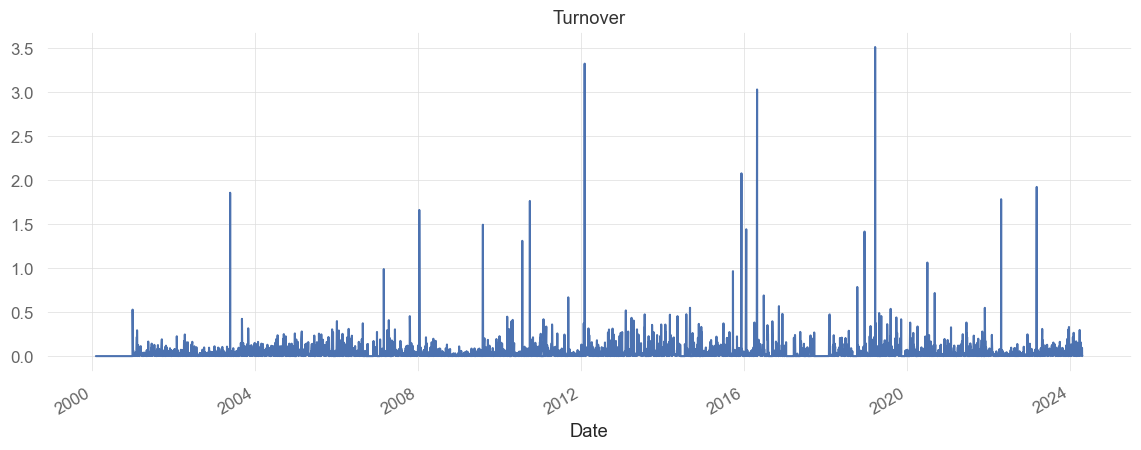

In [ ]:
#%%

turnover = abs(vol_signal.diff())

# Shift by -1 to get the date at which the transaction occurred, which was at close yesterday.
turnover = turnover.shift(-1)
turnover.plot(title='Turnover', figsize=(14, 5))
plt.show()

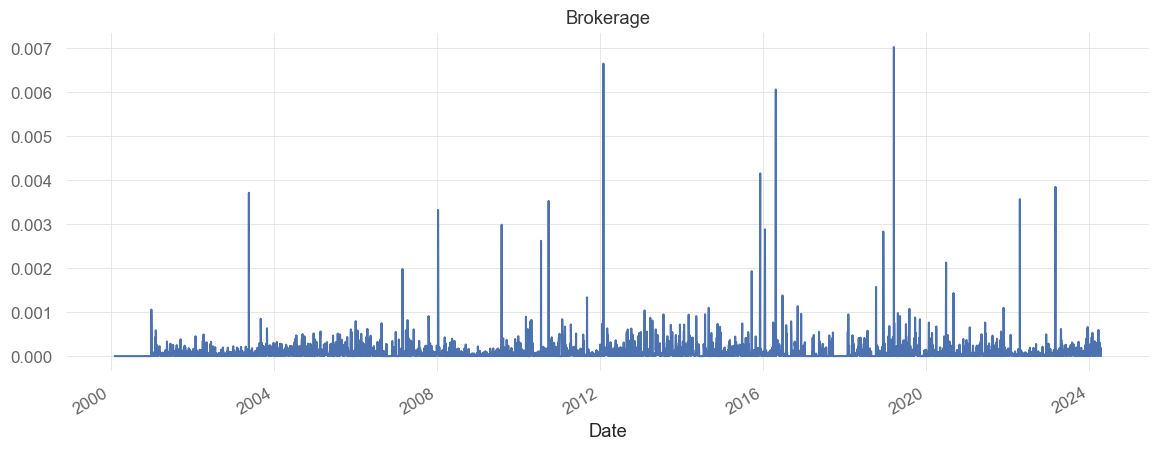

In [ ]:
#%%

# Compute brokerage fees
brokerage_fees = 0.0020  # 20 basis points
brokerage = turnover * brokerage_fees

# Plot Brokerage
brokerage.plot(title='Brokerage', figsize=(14, 5))
plt.show()

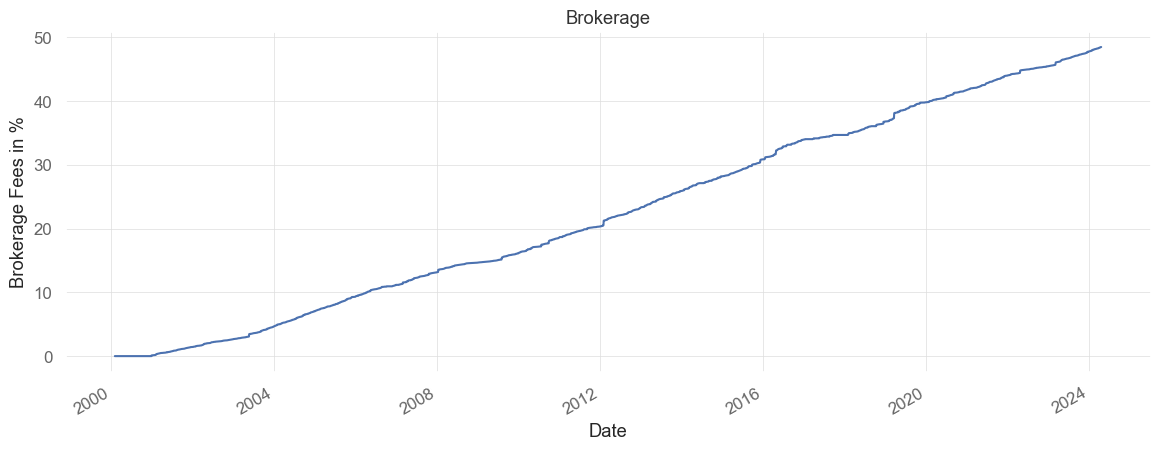

In [ ]:
#%%

# Plot Cum Brokerage
(brokerage.cumsum()*100).plot(title='Brokerage', figsize=(14, 5))
plt.ylabel('Brokerage Fees in %')
plt.show()

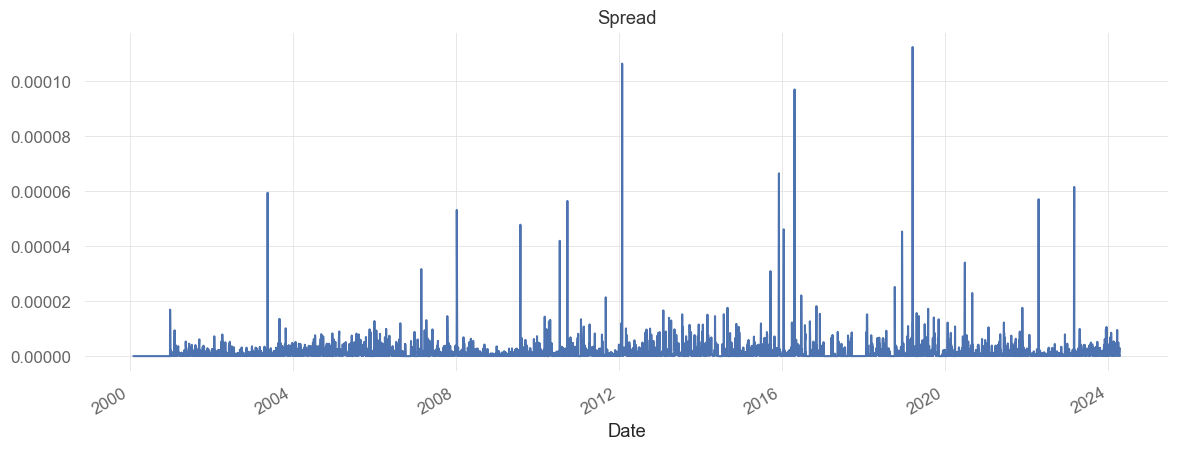

In [ ]:
#%%

# Compute Spread fee
bid_ask_fee =0.000032  # 0.32 basis points
spread = turnover * bid_ask_fee

# Plot Brokerage
spread.plot(title='Spread', figsize=(14, 5))
plt.show()

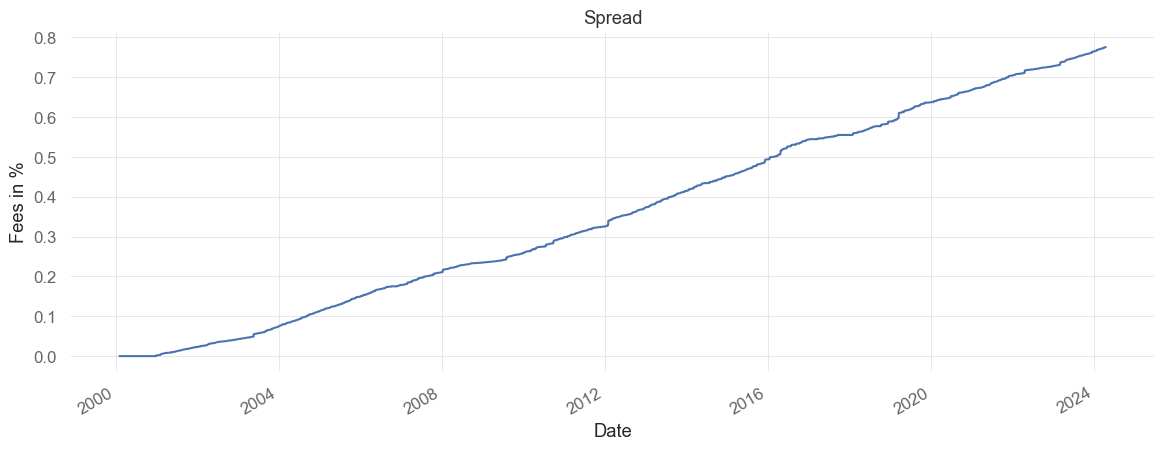

In [ ]:
#%%

# Plot Cum Spread
(spread.cumsum()*100).plot(title='Spread', figsize=(14, 5))
plt.ylabel('Fees in %')
plt.show()

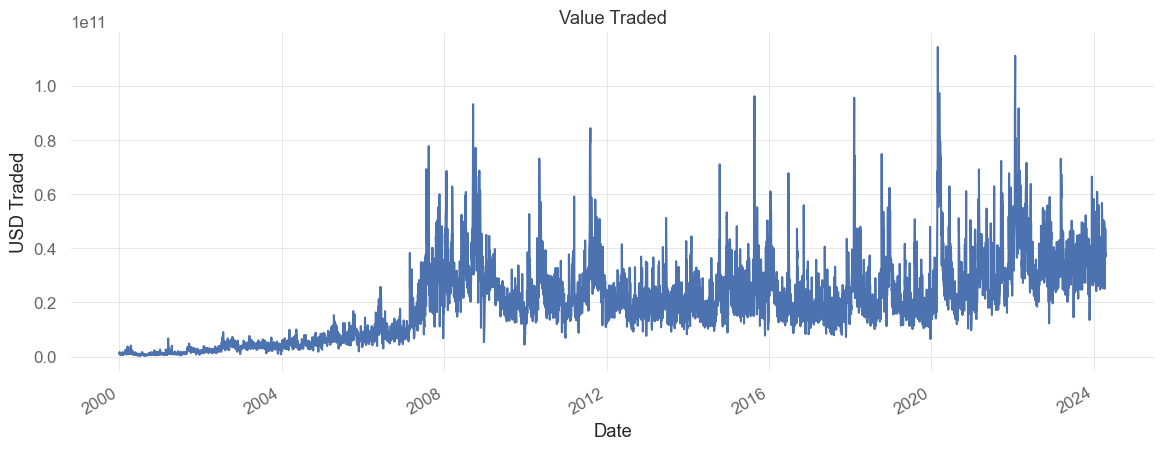

In [ ]:
#%%

# Volume on SPY is massive, we are probably never going to be 1% of ADV
daily_value = df['Volume'] * df['Close']
daily_value.plot(title='Value Traded', figsize=(14, 5))
plt.ylabel('USD Traded')
plt.show()

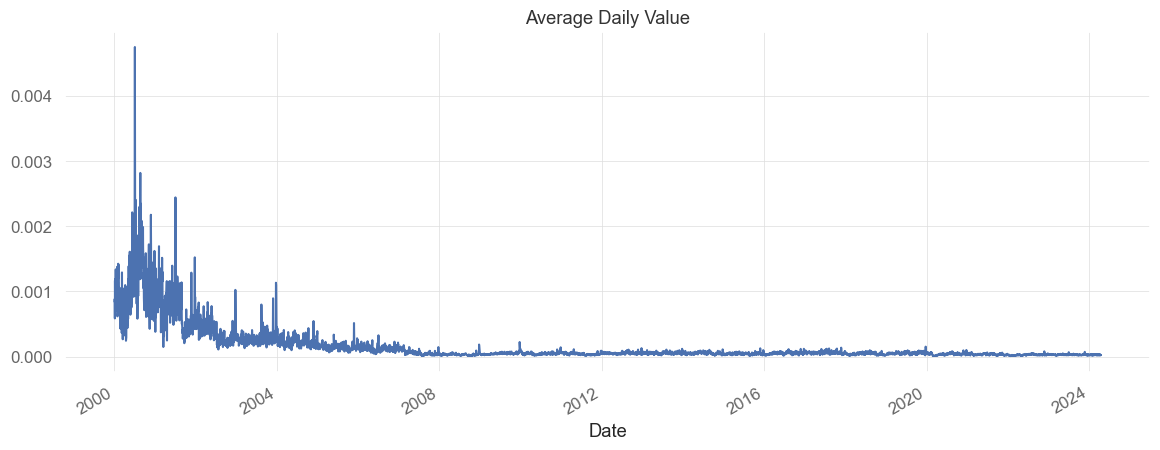

In [ ]:
#%%

# Lets assume we are going to have a maximum of 1'000'000 USD traded on any day, therefor
adv = 1000000 / daily_value
adv.plot(title='Average Daily Value', figsize=(14, 5))
plt.show()

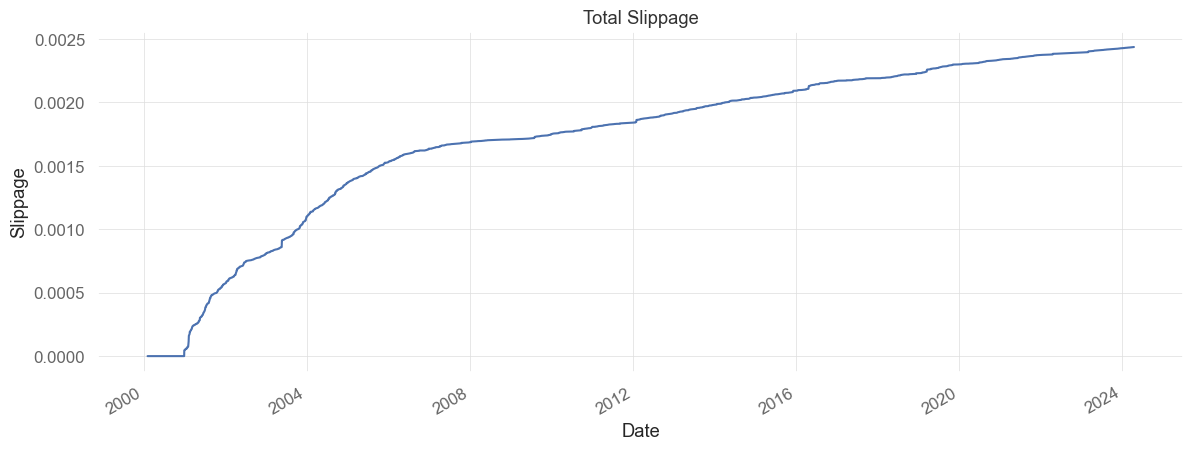

In [ ]:
#%%

# Lets use this to compute slippage costs, linearly (This is not the Linear Model)
# If 1% = 10 basis points then every 10 basis points of ADV can be 1 basis point of slippage.
cost = (adv / 0.01) * 0.0010
slippage = cost * turnover

# Plot total slippage
slippage.cumsum().plot(title='Total Slippage', figsize=(14, 5))
plt.ylabel('Slippage')
plt.show()

In [ ]:
#%%

# Total Slippage is less 25 basis points for the entire period, assuming a max $1Million a day transaction

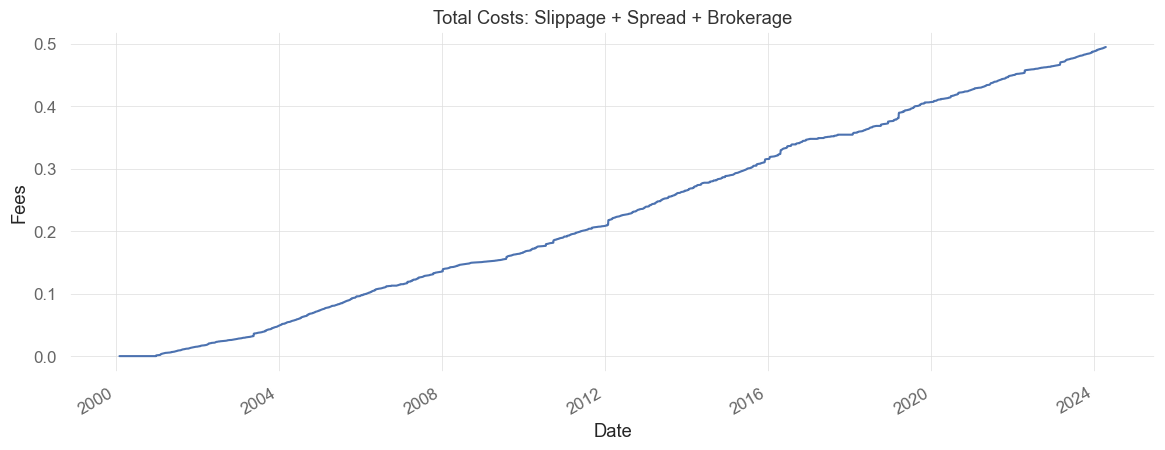

In [ ]:
#%%

total_costs = slippage + spread + brokerage

# Plot total costs
total_costs.cumsum().plot(title='Total Costs: Slippage + Spread + Brokerage', figsize=(14, 5))
plt.ylabel('Fees')
plt.show()

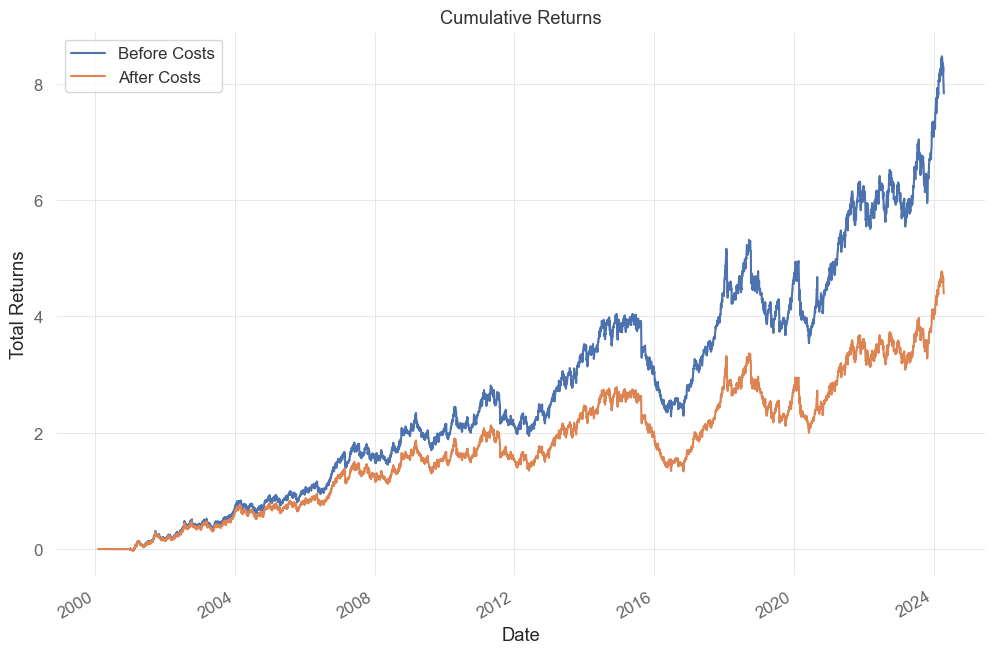

In [ ]:
#%%

# Plot the cumulative rets (compounded growth)
# Before costs
((strategy_voltgt_returns + 1).cumprod()-1).plot()

# After Costs
after_cost = strategy_voltgt_returns - total_costs 
((after_cost + 1).cumprod()-1).plot(figsize = (12, 8))

# Plot Cum returns
plt.title('Cumulative Returns')
plt.legend(['Before Costs', 'After Costs'])
plt.ylabel('Total Returns')
plt.show()

In [ ]:
#%%

sr_before = strategy_voltgt_returns.mean() / strategy_voltgt_returns.std() * np.sqrt(252)
sr_after  = after_cost.mean() / after_cost.std() * np.sqrt(252)

print(f'Sharpe Ratio Before: {sr_before.round(2)}')
print(f'Sharpe Ratio After: {sr_after.round(2)}')

Sharpe Ratio Before: 0.65
Sharpe Ratio After: 0.52
